In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
datadir = 'Data'

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir,  'driving_log.csv'), names = columns)

pd.set_option('display.max_colwidth', None)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\center_2023_04_15_16_51_51_441.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\left_2023_04_15_16_51_51_441.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\right_2023_04_15_16_51_51_441.jpg,0.0,0.0,0.0,0.000081
1,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\center_2023_04_15_16_51_51_543.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\left_2023_04_15_16_51_51_543.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\right_2023_04_15_16_51_51_543.jpg,0.0,0.0,0.0,0.000081
2,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\center_2023_04_15_16_51_51_644.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\left_2023_04_15_16_51_51_644.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\right_2023_04_15_16_51_51_644.jpg,0.0,0.0,0.0,0.000088
3,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\center_2023_04_15_16_51_51_745.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\left_2023_04_15_16_51_51_745.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\right_2023_04_15_16_51_51_745.jpg,0.0,0.0,0.0,0.000084
4,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\center_2023_04_15_16_51_51_847.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\left_2023_04_15_16_51_51_847.jpg,C:\Users\bobco\PycharmProjects\self-driving-car-course\IMG\right_2023_04_15_16_51_51_847.jpg,0.0,0.0,0.0,0.000081


In [3]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

In [4]:
data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)


[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


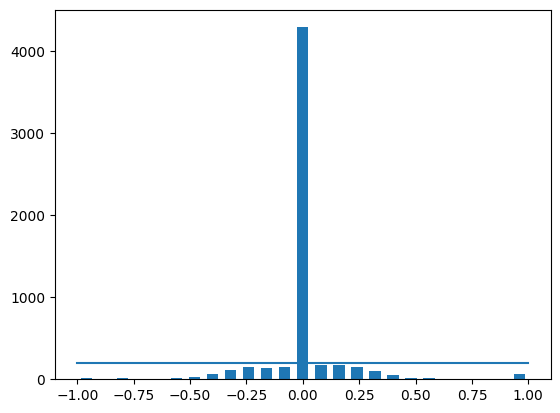

In [5]:
num_bins = 25
samples_per_bin = 200


hist, bins = np.histogram(data['steering'], num_bins)

center = (bins[:-1]+bins[1:]) * 0.5

print(center)

plt.bar(center, hist, width=0.05)

plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [6]:
# We could have skipped this with more thorough data. Re-do with recovery laps

print('total data:', len(data))

remove_list = []


for j in range(num_bins):
    list_ = []
    
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
print('removed: ', len(remove_list))

data.drop(data.index[remove_list], inplace=True)

print('remaining:', len(data))

total data: 5753
removed:  4089
remaining: 1664


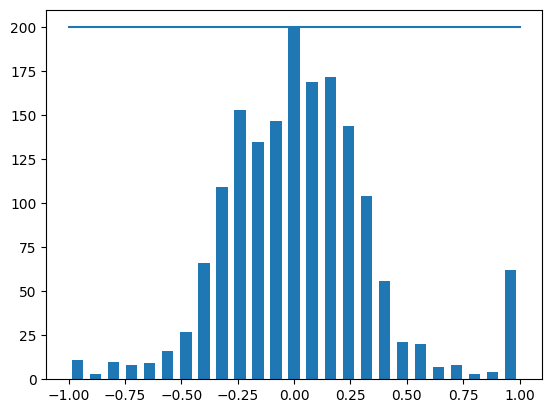

In [7]:
hist, _ = np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [8]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)



In [9]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)

print(f"Training Samples: {len(X_train)}\n Valid Samples: {len(X_test)}")

Training Samples: 1331
 Valid Samples: 333


Text(0.5, 1.0, 'Test Set')

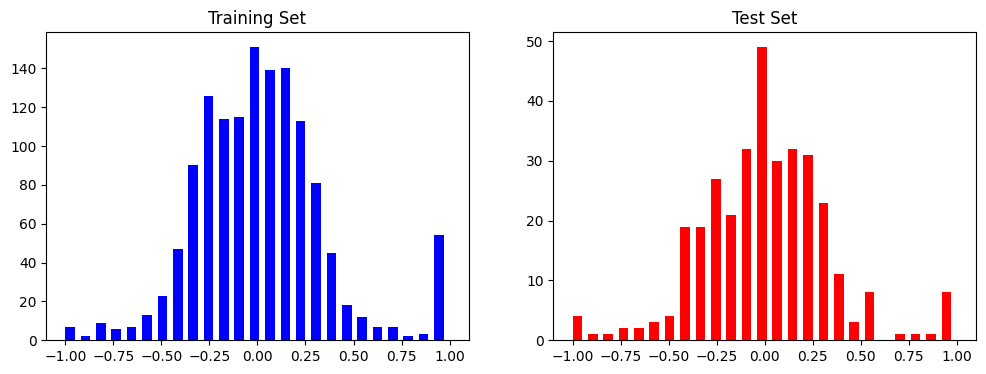

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
ax[0].set_title('Training Set')

ax[1].hist(y_test, bins=num_bins, width=0.05, color='red')
ax[1].set_title('Test Set')

In [11]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocssed Image')

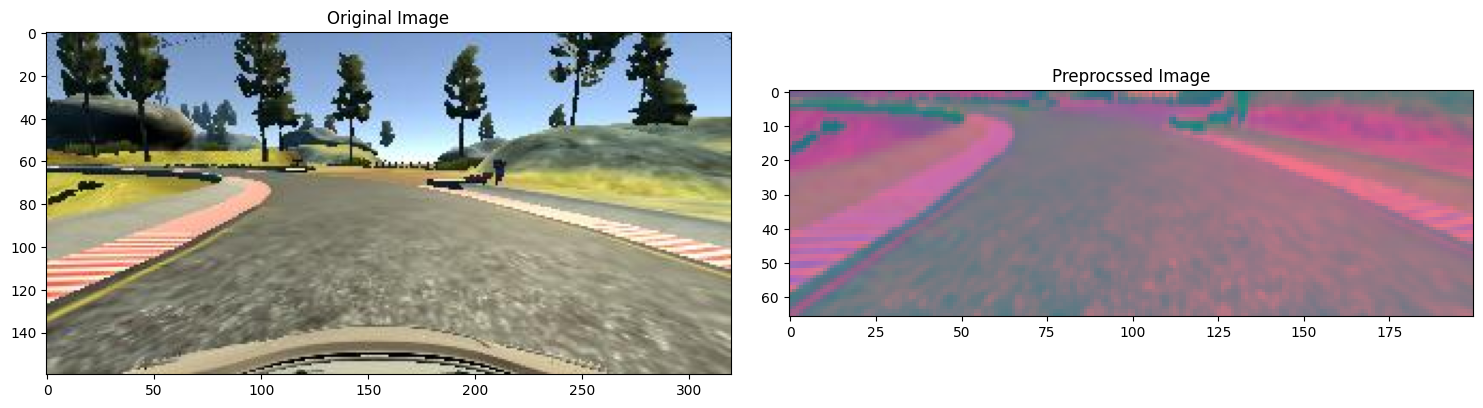

In [12]:
image = image_paths[100]
original_image = mpimg.imread(image)

preprocessed_image = img_preprocess(image)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

ax[0].imshow(original_image)
ax[0].set_title("Original Image")

ax[1].imshow(preprocessed_image)
ax[1].set_title("Preprocssed Image")

In [13]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_test = np.array(list(map(img_preprocess, X_test)))

(1331, 66, 200, 3)


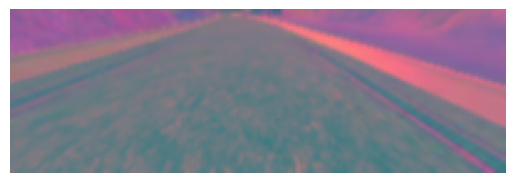

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

def nvidia_model():
 
model = Sequential()
 
model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
 
model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.5))
 
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
 
 
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation ='relu'))
model.add(Dense(1))
 
 
optimizer= Adam(lr=1e-3)
model.compile(loss='mse', optimizer=optimizer)
 
return model

In [15]:
def nvidia_model():

    model = Sequential()

    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))

    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))


    optimizer= Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model

In [16]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

C:\Users\bobco\anaconda3\envs\ml-cuda-2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
metrics = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=100,
          verbose=1, shuffle=1, callbacks=[EarlyStopping(monitor='val_loss', patience=20)])

Epoch 1/100
14/14 [==============================] - 4s 33ms/step - loss: 0.1701 - val_loss: 0.1095
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1245 - val_loss: 0.1086
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1183 - val_loss: 0.1089
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 0.1192 - val_loss: 0.1084
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1160 - val_loss: 0.1080
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1147 - val_loss: 0.1070
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1147 - val_loss: 0.1074
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.1155 - val_loss: 0.1065
Epoch 9/100
14/14 [==============================] - 0s 16ms/step - loss: 0.1132 - val_loss: 0.1051
Epoch 10/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1055 - val_loss: 0.1015

14/14 [==============================] - 0s 15ms/step - loss: 0.0588 - val_loss: 0.0693
Epoch 83/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0659 - val_loss: 0.0588
Epoch 84/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0577 - val_loss: 0.0635
Epoch 85/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0580 - val_loss: 0.0563
Epoch 86/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0557 - val_loss: 0.0554
Epoch 87/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0606 - val_loss: 0.0609
Epoch 88/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0587 - val_loss: 0.0556
Epoch 89/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0515 - val_loss: 0.0576
Epoch 90/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0601 - val_loss: 0.0693
Epoch 91/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0622 - val_loss: 0.0644
Epo

Text(0.5, 0, 'Epoch')

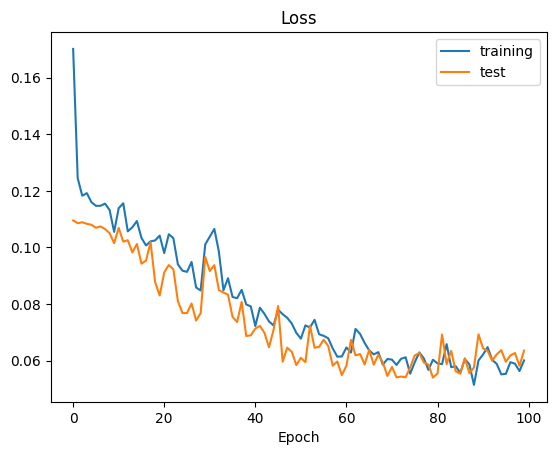

In [18]:
plt.plot(metrics.history['loss'])
plt.plot(metrics.history['val_loss'])
plt.legend(['training', 'test'])
plt.title('Loss')
plt.xlabel('Epoch')


In [19]:
model.save('model.h5')